### Title: 
# Exploratory Data Analysis

### Description:
We are going to perform an EDA of our dataset.

### Authors:
#### Hugo Cesar Octavio del Sueldo
#### Jose Lopez Galdon

### Date:
23/10/2020

### Version:
1.0

***

### Libraries

We are going to start this EDA loading the respective libraries

In [1]:
    # Numpy & Pandas to work with the DF
import numpy as np
import pandas as pd

    # Seaborn / matplotlib for graphs
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
    
    # Random samples
from random import sample

    # Visualize DF
from IPython.display import display, HTML

    # Import Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

    # Authomatic reports
import sweetviz as sv

***

## Load data

In [2]:
    # To automate the work as much as possible, we will parameterize the codes, so in this case, we will create an objetct with
    # the path root
name = 'data_train_merge'

data = pd.read_csv(f'../data/02_intermediate/{name}.csv',  # Path root: here we include an f-string with the variable name to parametrize
                   low_memory = False)                     # To avoid warnings we use set low_memory = False

***

## Variable predict

Taking into account the goals of the practice, we only want to know those persons that `Fully paid` their loans or those who does not, so we will tansform the dependent variable into binary problem, to ones or ceros depending on that condition.

So we are going to predict the variable `loan_status` which are classified in different sections:

- **Current**: Loan is up to date on all outstanding payments. 
 
- **In Grace Period**: Loan is past due but within the 15-day grace period. 
 
- **Late (16-30)**: Loan has not been current for 16 to 30 days.
 
- **Late (31-120)**: Loan has not been current for 31 to 120 days. 
 
- **Fully paid**: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.
 
- **Default**: Loan has not been current for an extended period of time.
 
- **Charged Off***: Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. 

As we know, our problem is to predict who is going to pay or not. Due to this we will select **Fully paid**, **Default** and **Charged Off**. **default** and **Charged Off** will be treated as the same variable, because they almost explain the same condition:

*Loans that are in "Default" are loans for which borrowers have failed to make payments for an extended period of time.*
 
*A loan becomes “Charged Off” when there is no longer a reasonable expectation of further payments.  Charge Off typically occurs when a loan is 120 days or more past due and there is no reasonable expectation of sufficient payment to prevent the charge off.  In certain circumstances, loans may be charged off at an earlier or later date.  Please note, loans for which borrowers have filed for bankruptcy may be charged off earlier based on the date of bankruptcy notification.*
 
*A loan that is in “Default” will still appear in your Notes, in the status of “Default,” while a loan that has been “Charged Off” will appear as charged off, and the remaining principal balance of the Note will be deducted from your account balance.*

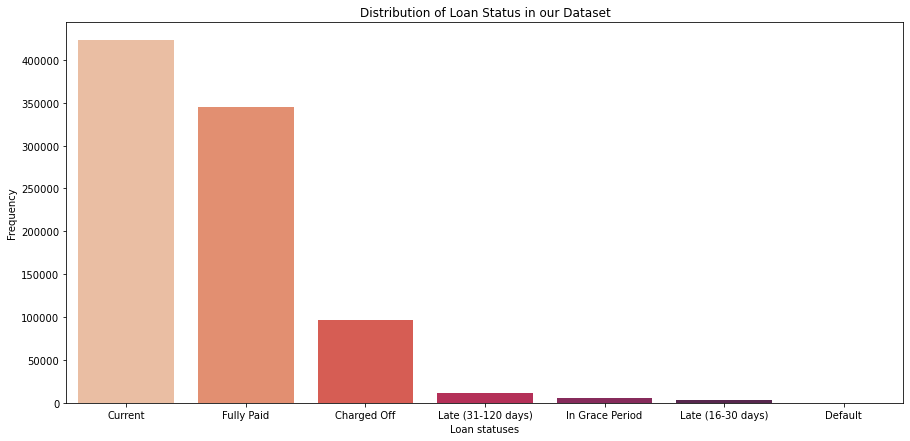

In [3]:
    # First we create a dataset with the loan_status variables
loan = data['loan_status'].value_counts()
loan = loan.to_frame()
loan.reset_index(inplace = True)

    # We set the name columns
loan.columns = ['Loan Status', 'Count']

    # Set the heigth and width size
plt.subplots(figsize = (15, 7))

    # Plot with seaborn
sns.barplot(y='Count', x='Loan Status', data = loan, palette = 'rocket_r');

    # Labels
plt.xlabel("Loan statuses");
plt.ylabel("Frequency");
plt.title("Distribution of Loan Status in our Dataset");

As you can see, we have a lot of loans which are current with fair amount of fully paid loans. Other categories (including) default have a really low number. This could mean that the data is imbalanced and we might need to do something about this later in the analysis. Therefore, we will merge **Charged Off** and **Default**, this will be our *non-payment* variable.

In [4]:
    # Merge Default & Charged Off
data['loan_status'] = data['loan_status'].replace({'Default':'Charged Off'})

    # We will only select those observations with "Fully Paid" & "Charged Off"
data_binary = data[(data['loan_status'] == "Fully Paid") | (data['loan_status'] == "Charged Off")]

    # Now, we will transform into 0 & 1
dummy_dict = {"Fully Paid":0, "Charged Off":1}

    # Finally, we use the dictiony in the dataset
data = data_binary.replace({"loan_status": dummy_dict})

We will perform the same graph...

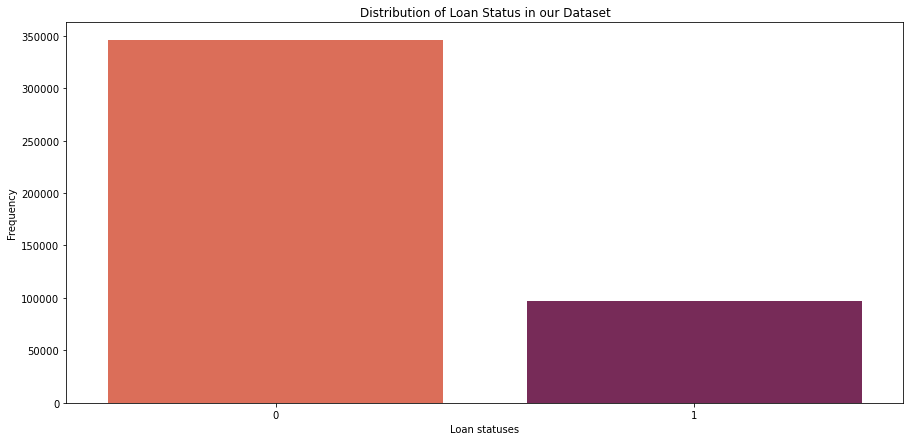

In [5]:
    # First we create a dataset with the loan_status variables
loan = data['loan_status'].value_counts()
loan = loan.to_frame()
loan.reset_index(inplace = True)

    # We set the name columns
loan.columns = ['Loan Status', 'Count']

    # Set the heigth and width size
plt.subplots(figsize = (15, 7))

    # Plot with seaborn
sns.barplot(y='Count', x='Loan Status', data = loan, palette = 'rocket_r');

    # Labels
plt.xlabel("Loan statuses");
plt.ylabel("Frequency");
plt.title("Distribution of Loan Status in our Dataset");

As we said before we may have an imbalanced dataset, if we run the algorithms with this proportion it will bias to the ceros(payment), so if we recieve a new client will have more probability to be a cero than a one, and that could lead us to the wrong decission.

### View data

Firstly, we are goint to take a look to our dataframe:

In [6]:
    # First 5 rows using html display in order to view all the columns
data = data
display(HTML(data.head().to_html()))

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
8,112038251,NaN,11575,11575,11575.0,36 months,7.35%,359.26,A,A4,Solutions Architect,6 years,OWN,153000.0,Not Verified,Jun-2017,0,n,https://lendingclub.com/browse/loanDetail.action?loan_id=112038251,NaN,credit_card,Credit card refinancing,923xx,CA,16.99,0,Jul-1994,720,724,0,24.0,84.0,20,1,8550,22.7%,46,w,0.0,0.0,11707.816236,11707.82,11575.0,132.82,0.0,0.0,0.0,Sep-2017,11360.38,NaN,Sep-2017,724,720,0,24.0,1,Individual,NaN,NaN,NaN,0,0,442731,1.0,1.0,0.0,0.0,27.0,92315.0,63.0,2.0,8.0,1581.0,36.0,37600,1.0,6.0,2.0,8,23302.0,24269.0,13.6,0,0,130.0,275,3,3,2,3.0,NaN,7.0,NaN,0,6,9,9,16,12,16,32.0,9,20,0.0,0,0,2,95.7,11.1,1,0,528172,100865,28100,120572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
10,112149045,NaN,7200,7200,7200.0,36 months,24.85%,285.70,E,E3,Pse,2 years,RENT,50000.0,Source Verified,Jun-2017,0,n,https://lendingclub.com/browse/loanDetail.action?loan_id=112149045,NaN,debt_consolidation,Debt consolidation,985xx,WA,6.07,0,Jan-2000,685,689,0,72.0,NaN,4,0,3560,98.9%,5,w,0.0,0.0,7206.461000,7206.46,7200.0,6.46,0.0,0.0,0.0,Jul-2017,7231.31,NaN,Sep-2017,669,665,0,72.0,1,Individual,NaN,NaN,NaN,0,0,5588,0.0,1.0,0.0,1.0,21.0,2028.0,51.0,0.0,1.0,2779.0,74.0,3600,0.0,0.0,0.0,2,1863.0,40.0,98.9,0,0,21.0,172,14,14,0,14.0,NaN,14.0,NaN,1,2,2,3,3,1,3,3.0,2,4,0.0,0,0,0,80.0,100.0,0,0,7600,5588,3600,4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
24,112052261,NaN,7500,7500,

In [7]:
    # Last 5 rows using html display in order to view all the columns
data = data
display(HTML(data.tail().to_html()))

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
884869,36221446,NaN,11575,11575,11575.0,36 months,15.59%,404.61,D,D1,Manager,10+ years,RENT,25400.0,Verified,Jan-2015,0,n,https://lendingclub.com/browse/loanDetail.action?loan_id=36221446,NaN,credit_card,Credit card refinancing,791xx,TX,27.08,0,Jul-1999,680,684,0,NaN,NaN,9,0,18266,65%,18,f,0.0,0.0,13976.740000,13976.74,11575.00,2401.74,0.0,0.00,0.0000,Sep-2016,6281.14,NaN,Nov-2016,694,690,0,NaN,1,Individual,NaN,NaN,NaN,0,0,19798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28100,NaN,NaN,NaN,1,2200.0,9234.0,66.4,0,0,113.0,184,48,8,0,48.0,NaN,14.0,NaN,0,7,7,7,10,5,8,13.0,7,9,0.0,0,0,1,100.0,42.9,0,0,29866,19798,27500,1766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
884870,36330911,NaN,12000,12000,12000.0,36 months,11.99%,398.52,B,B5,KYC Business Analyst,< 1 year,MORTGAGE,63000.0,Verified,Jan-2015,1,n,https://lendingclub.com/browse/loanDetail.action?loan_id=36330911,NaN,credit_card,Credit card refinancing,432xx,OH,23.69,1,Jun-1995,685,689,0,9.0,NaN,13,0,21110,69.7%,61,f,0.0,0.0,5164.770000,5164.77,3847.36,1317.41,0.0,0.00,0.0000,Feb-2016,398.52,NaN,Feb-2017,629,625,0,9.0,1,Individual,NaN,NaN,NaN,0,0,237002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30300,NaN,NaN,NaN,11,18231.0,4776.0,69.0,0,0,121.0,233,1,1,1,1.0,NaN,14.0,NaN,1,4,8,4,5,40,8,20.0,8,13,0.0,0,1,3,98.3,50.0,0,0,325484,112990,15400,98125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
884873,36271333,NaN,13

In [8]:
    # Data dimension
data.shape

(442601, 151)

### Data wrangling

After studying the whole dictionary, place in `references/dictionary.md`, we saw that there are some variables that we can not use them, because is information a posteriori, some examples of these columns are: `collection_recovery_fee`, `installment`, `last_credit_pull_d`, `last_pymnt_amnt`...

In [9]:
    # First, we make an objetc with the information of these columns
columns = ["collection_recovery_fee", "dti", "dti_joint", "fico_range_high", "fico_range_low", "grade", "initial_list_status", 
           "installment", "last_credit_pull_d", "last_fico_range_high", "last_fico_range_low", "last_pymnt_amnt", 
           "last_pymnt_d", "loan_amnt", "mths_since_last_delinq", "mths_since_last_major_derog", "mths_since_rcnt_il", 
           "next_pymnt_d", "mths_since_recent_bc", "mths_since_recent_bc_dlq", "mths_since_recent_inq", 
           "mths_since_recent_revol_delinq", "out_prncp", "out_prncp_inv", "pymnt_plan", "recoveries", "sub_grade", 
           "tot_coll_amt", "tot_cur_bal", "total_bal_ex_mort", "total_pymnt", "total_pymnt_inv", "total_rec_int", 
           "total_rec_late_fee", "total_rec_prncp", "total_rev_hi_lim", "verification_status", "verification_status_joint",
           "issue_d", "earliest_cr_line", "hardship_flag"]

    # Then we drop those columns
data = data.drop(columns = columns)

Once we have viewed our dataset, we continue exploring the column types and nulls...

In [10]:
data.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442601 entries, 8 to 884875
Data columns (total 110 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   id                                          442601 non-null  int64  
 1   member_id                                   0 non-null       float64
 2   funded_amnt                                 442601 non-null  int64  
 3   funded_amnt_inv                             442601 non-null  float64
 4   term                                        442601 non-null  object 
 5   int_rate                                    442601 non-null  object 
 6   emp_title                                   417584 non-null  object 
 7   emp_length                                  418726 non-null  object 
 8   home_ownership                              442601 non-null  object 
 9   annual_inc                                  442601 non-null  float64


As we can see above we have plenty of columns with nulls, so we are going to drop those columns which more than a 75% of the information is null.

In [11]:
    # For this operation we will use drop.na(), but firstly we will create an objet with the scale
thresh = round(len(data) * 0.75) 

data = data.dropna(thresh = thresh, axis = 1)

    #Lets check the data shape
data.shape

(442601, 60)

We can see that now we have only 64 columns, instead of 151. This is a huge reduction of the variables, but we continue having too much, in order to reduce them, we will study which of them are important in order to predict `loan_status`.

Other method we can use in order to select those variables which are important is, we could use a correlation matrix and select those whith hight correlation values, but with 65 columns will be too difficult... so we will use a smarter way:

*Select those variables with more than 80% of correlation between them and drop them*

In [12]:
    # To start, we create our objet called "correlated_features" and our correlation parameter
correlated_features = set()
corr_param = 0.8

    # Them, we drop our predict variable
correlation_matrix = data.drop('loan_status', axis=1).corr()

    # Finally we use a loop
for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > corr_param:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)

correlated_features

{'funded_amnt_inv',
 'num_bc_sats',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_30dpd',
 'percent_bc_gt_75',
 'tot_hi_cred_lim',
 'total_bc_limit'}

In [13]:
data = data.drop(correlated_features, axis = 1)

Now we will drop those columns which are not important to predict `loan_status`, using our business knowlege, some examples of them are `url`, `policy_code`, `title`, `purpose`...

In [14]:
    # First, we make an objetc with the information of these columns
columns = ["emp_title", "id", "policy_code", "purpose", "title", "url", "zip_code"]

    # Then we drop those columns
data = data.drop(columns = columns)

    # Check the dataset
data.shape

(442601, 43)

### Recursive Featuring Elimination

As we can see we have reduced the dataset a 33% but we still have to much columns, so, we are going to use RFE (Recursive Featuring Elimination) algorithm that *is basically a backward selection of the predictors. This technique begins by building a model on the entire set of predictors and computing an importance score for each predictor. The least important predictor(s) are then removed, the model is re-built, and importance scores are computed again. In practice, the analyst specifies the number of predictor subsets to evaluate as well as each subset’s size. Therefore, the subset size is a tuning parameter for RFE. The subset size that optimizes the performance criteria is used to select the predictors based on the importance rankings. The optimal subset is then used to train the final model.*

First of all, in order to run this algorithm we have to modify the columns types because it is a must to codify the categorical variables. Therefore, we will move forward analysing those columns that could changed for categorical and those that have symbols that could affect the code in a next step.

- `int_rate`, `revol_util`: Lets delete the "%" and convert the variable into a float object

- `emp_length`, `home_ownership`, `term`, **`loan_status`**, `addr_state`, `application_type`, `disbursement_method`, `debt_settlement_flag`: Codify 

In [15]:
    # With a apply and lamba function we, in the same line, convert the variable into a float and we drop the last 
    # element.
data['int_rate'] = data['int_rate'].apply(lambda x: float(x[:-1]))

In [16]:
    # Now, we convert the revol_util variable into an string object and the apply the same lamba function as above
data["revol_util"] = data["revol_util"].astype('category') 
data['revol_util'] = data['revol_util'].apply(lambda x: float(x[:-1])) 

In [17]:
    # We create and object we those variable that we want to convert into a categorical named columns_categ
columns_categ = ["emp_length", "home_ownership", "loan_status", "addr_state", "application_type", "term",
                 "disbursement_method", "debt_settlement_flag"]
    
    # Below, we transform the variables into categorical with the astype function.
data[columns_categ] = data[columns_categ].astype('category')

In [18]:
    #with a lambda and apply function we convert the different categories into the variable to a number 
data[columns_categ] = data[columns_categ].apply(lambda x: x.cat.codes)

Now, lets check the results of the functions created above

In [19]:
display(HTML(data.head().to_html()))

,funded_amnt,term,int_rate,emp_length,home_ownership,annual_inc,loan_status,addr_state,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,application_type,acc_now_delinq,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_il_high_credit_limit,disbursement_method,debt_settlement_flag
8,11575,0,7.35,6,2,153000.0,0,4,0,0,20,1,8550,22.7,46,0,0,0,8,23302.0,24269.0,13.6,0,0,130.0,275,3,3,2,0,6,9,16,12,0.0,0,2,95.7,1,0,120572,0,0
10,7200,0,24.85,2,3,50000.0,0,47,0,0,4,0,3560,98.9,5,0,0,0,2,1863.0,40.0,98.9,0,0,21.0,172,14,14,0,1,2,2,3,1,0.0,0,0,80.0,0,0,4000,0,0
24,7500,0,7.35,7,1,110000.0,0,43,0,2,19,0,23348,27.2,27,0,0,0,13,14551.0,60352.0,27.9,0,0,48.0,51,3,3,4,0,11,11,13,8,0.0,0,3,100.0,0,0,32239,0,0
42,10000,1,16.02,7,3,51979.0,0,4,0,0,15,2,5733,20.0,21,0,0,0,7,730.0,14628.0,22.2,0,0,130.0,54,6,6,0,0,3,7,8,4,0.0,0,3,100.0,2,0,5500,0,0
91,14000,0,16.02,7,1,75000.0,0,19,1,0,4,0,2700,90.0,10,0,0,0,5,31911.0,300.0,90.0,0,0,109.0,97,5,5,1,0,1,1,5,3,0.0,0,3,90.0,0,0,30321,0,0


To move forward with the RFE algorithm we need to drop the NaN's because it doesn't run with them, so let use the dropna function.

In [20]:
data = data.dropna() 
data.shape

(407319, 43)

As we can observe, we change from 442567 rows to 407290.

Due to the RFE algorithm it's so intensive in compute, and therefore expend to much time to drop the results we will work, at this stage, with a sample of 1000 random rows.

In [21]:
    #With the sample function, we create the sample with a seed and with replacement
minidata = data.sample(n = 1000, replace = True, random_state = 1322)

In [22]:
minidata.shape  #lets check the results

(1000, 43)

Finally, we can start with the RFE algorithm to select the variables

In [23]:
'''
X: it is the minidata df with the independent variables
target: it is the vector with the dependent variable
'''

X = minidata.drop('loan_status', axis=1)
target = minidata['loan_status']

In [24]:
'''
rfc: it is the object that contains the RandomForestClassifier that we will use in the RFECV.
'''
rfc = RandomForestClassifier(random_state=1322)

In [25]:
'''
rfecv: it is an RFE with Cross Validation. 
    Parameters:
        Estimator = the object rfc created above that contains the information about the feature importance
        step = number of features to remove at each iteration
        cv = currently, we are using a StratifiedKFold cross validation with k equals to 10
        scoring = the metric chosen.
'''

rfecv = RFECV(estimator = rfc, step = 1, cv = StratifiedKFold(10), scoring = 'accuracy')

'''
rfecv.fit: this function fitted the predictive variable according to our model
'''

rfecv.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=1322), scoring='accuracy')

Once the execution finishes, you can use this line of code to see how many features are optimal to produce the best accuracy (or whatever your chosen metric is):

In [26]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 23


Not only this, but you can also plot the accuracy obtained with every number of features used:

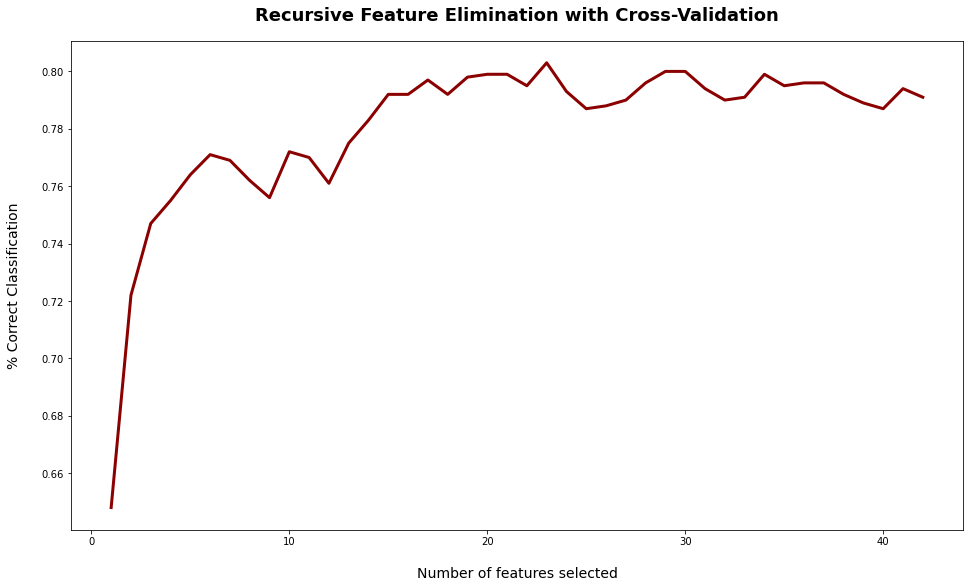

In [27]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color = 'darkred', linewidth=3)

plt.show()

It is visible that with 23 features the accuracy was close to 80%, which is very good taking account that we initially have 150 variables. 

You can also print out which features are considered to be least important and drop them with this snippet:

In [28]:
print(np.where(rfecv.support_ == False)[0])

X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[ 1  4  7  8 10 14 15 16 21 22 27 28 29 33 34 35 37 38 40]


The instance of RFECV has also a nifty feature_importances attribute which is worthy to be checked out

In [29]:
rfecv.estimator_.feature_importances_

array([0.05274335, 0.08803884, 0.02485464, 0.05830483, 0.03448533,
       0.03374042, 0.04913812, 0.04245294, 0.03705807, 0.02853572,
       0.05122693, 0.04720558, 0.04700756, 0.05136612, 0.06318963,
       0.03601058, 0.03111898, 0.03573326, 0.03296601, 0.03213208,
       0.02659227, 0.05134347, 0.04475525])

Okay, okay, don’t scream at me just yet. I know that this doesn’t tell you much. Thankfully, this is pretty easy to visualize. One way is to create a DataFrame object with attributes as one column and the importance as the other, and then just simply sort the DataFrame by importance in descending order. Then you can use the power of plotting libraries such as Matplotlib to draw a Bar chart (horizontal is preferred for this scenario) to get a nice visual representation. Here’s the code for doing so:

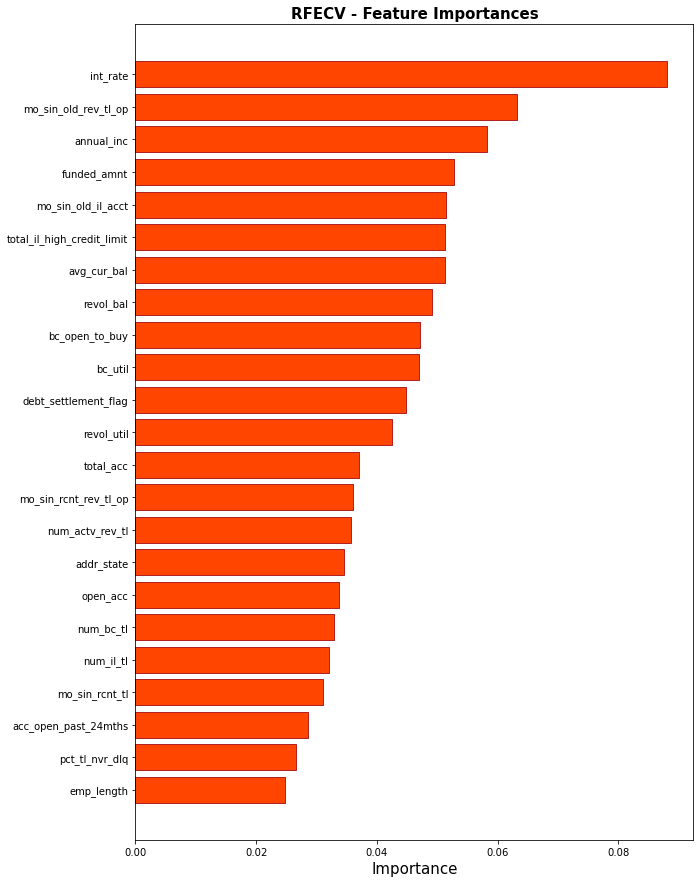

In [30]:
'''
Firstly, we create an emplty df.
Second, we create two columns. One for the variables names and another with the % importance of each.

Finnaly, we sort them in ascending order.
'''

df_viz = pd.DataFrame()
df_viz['attr'] = X.columns
df_viz['importance'] = rfecv.estimator_.feature_importances_

df_viz = df_viz.sort_values(by='importance', ascending=True)

    # Bar Plot
plt.figure(figsize = (10, 15))
plt.barh(y = df_viz['attr'], width = df_viz['importance'], color = 'orangered', edgecolor = 'firebrick')
plt.title('RFECV - Feature Importances', fontsize = 15, fontweight = 'bold')
plt.xlabel('Importance', fontsize = 15)
plt.show()

At this stage, the most important variable is the int_rate(`interest rate`), this make sense because when we have a client with high interest rate, this is due to a high risk. The interest rate depends of the total amount of the loan, the term, the `emp_title`, `emp_length`... so on.

The number of mortage accounts (`mort_acc`) it isn't signicate explaining the loaning state. That is a little weird because a person with multiple mortage account could be a risky customer and probably a default borrower.

***

## Exploratory Data Analysis

In statistics, exploratory data analysis is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. A statistical model can be used or not, but primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task. 

In [31]:
    # Select the columns of the RFECV
columns = ['loan_status', 'funded_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership', 'annual_inc', 'addr_state', 
           'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 'acc_open_past_24mths', 'avg_cur_bal',
           'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct','mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
           'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_tl', 'num_il_tl', 
           'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'total_il_high_credit_limit', 'debt_settlement_flag']

    # Create a new dataset
dataset = data[columns]

    # With the sample function, we create the sample with a seed and with replacement
#dataset = minidata.sample(n = 1000, replace = True, random_state = 1322)

Now, we will check the data info.

In [32]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407319 entries, 8 to 884875
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   loan_status                 407319 non-null  int8    
 1   funded_amnt                 407319 non-null  int64   
 2   term                        407319 non-null  int8    
 3   int_rate                    407319 non-null  float64 
 4   emp_length                  407319 non-null  int8    
 5   home_ownership              407319 non-null  int8    
 6   annual_inc                  407319 non-null  float64 
 7   addr_state                  407319 non-null  int8    
 8   inq_last_6mths              407319 non-null  int64   
 9   open_acc                    407319 non-null  int64   
 10  revol_bal                   407319 non-null  int64   
 11  revol_util                  407319 non-null  category
 12  total_acc                   407319 non-null  int64   
 13 

We can see that some of theme are not in the correct type, so we will modify them.

In [33]:
dataset = dataset.copy()
    # We create and object we those variable that we want to convert into a categorical named columns_categ
columns_categ = ['term', 'emp_length', 'home_ownership', 'addr_state', 'debt_settlement_flag']
    
    # Below, we transform the variables into categorical with the astype function.
dataset[columns_categ] = dataset[columns_categ].astype('category')

    # Other columns
dataset.loc['revol_util'] = dataset['revol_util'].astype('float64')
dataset.loc['inq_last_6mths'] = dataset['inq_last_6mths'].astype('float64')

In [34]:
    # Parametrize
dataset = dataset

In [35]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 407321 entries, 8 to inq_last_6mths
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_status                 407319 non-null  float64
 1   funded_amnt                 407319 non-null  float64
 2   term                        407319 non-null  object 
 3   int_rate                    407319 non-null  float64
 4   emp_length                  407319 non-null  object 
 5   home_ownership              407319 non-null  object 
 6   annual_inc                  407319 non-null  float64
 7   addr_state                  407319 non-null  object 
 8   inq_last_6mths              407319 non-null  float64
 9   open_acc                    407319 non-null  float64
 10  revol_bal                   407319 non-null  float64
 11  revol_util                  407319 non-null  object 
 12  total_acc                   407319 non-null  float64
 13  acc_open_pa

### Authomatic report

Firstly, we are going to perform an authomatic EDA report, with the Sweetviz:

In [36]:
# We will use the minidatset with the 30 variables used in the RFECV

    # Analyzing the dataset
#advert_report = sv.analyze(dataset)

    # Display the report
#advert_report.show_html('01_EDA_report.html')

### Correlations

A correlation coefficient is a numerical measure of some type of correlation, meaning a statistical relationship between two variables. The variables may be two columns of a given data set of observations, often called a sample, or two components of a multivariate random variable with a known distribution.

Several types of correlation coefficient exist, each with their own definition and own range of usability and characteristics. They all assume values in the range from −1 to +1, where ±1 indicates the strongest possible agreement and 0 the strongest possible disagreement.

In [37]:
display(HTML(dataset.corr().to_html()))

,loan_status,funded_amnt,int_rate,annual_inc,inq_last_6mths,open_acc,revol_bal,total_acc,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_tl_op_past_12m,pct_tl_nvr_dlq,total_il_high_credit_limit
loan_status,1.000000,0.056422,0.264910,-0.053432,0.060627,0.033363,-0.020318,-0.011463,0.101588,-0.090436,-0.093337,0.083944,-0.027343,-0.054994,-0.054383,-0.061137,-0.079612,0.008935,0.046588,0.080324,-0.016451,0.009147,0.086828,-0.008589,-0.001256
funded_amnt,0.056422,1.000000,0.133590,0.329325,-0.022661,0.174385,0.329716,0.198954,0.000933,0.237201,0.208753,0.050704,0.133876,0.171035,0.056327,0.035934,0.223964,-0.061279,0.196369,0.151639,0.190992,0.066591,-0.029136,0.092835,0.192083
int_rate,0.264910,0.133590,1.000000,-0.087100,0.236723,-0.006551,-0.037833,-0.047544,0.209257,-0.082288,-0.285257,0.243281,-0.090500,-0.131213,-0.123367,-0.147712,-0.064537,0.050545,0.021275,0.097510,-0.083609,-0.006423,0.233349,-0.069748,-0.022712
annual_inc,-0.053432,0.329325,-0.087100,1.000000,0.032627,0.120819,0.289246,0.167322,0.040371,0.321133,0.167706,-0.009130,0.119512,0.137861,0.040484,-0.013853,0.219119,0.019311,0.100936,0.064352,0.127374,0.087119,0.044854,-0.009452,0.256792
inq_last_6mths,0.060627,-0.022661,0.236723,0.032627,1.000000,0.135279,-0.023772,0.147500,0.253966,-0.032849,0.018532,-0.076969,0.011837,-0.009264,-0.180631,-0.221842,0.035303,0.068424,0.055193,0.096347,0.120452,0.068445,0.299375,-0.022747,0.047114
open_acc,0.033363,0.174385,-0.006551,0.120819,0.135279,1.000000,0.209923,0.689136,0.471063,-0.126037,0.288771,-0.110375,0.130329,0.129646,-0.226202,-0.208968,0.100512,0.007046,0.524243,0.649323,0.485848,0.390702,0.344129,0.115742,0.353125
revol_bal,-0.020318,0.329716,-0.037833,0.289246,-0.023772,0.209923,1.000000,0.173578,-0.025720,0.290407,0.194253,0.149815,0.096151,0.214792,0.037086,0.044226,0.188631,-0.090517,0.292189,0.286728,0.205176,0.000994,-0.034772,0.127521,0.105857
total_acc,-0.011463,0.198954,-0.047544,0.167322,0.147500,0.689136,0.173578,1.000000,0.421804,0.041706,0.219533,-0.098491,0.338804,0.282372,-0.164060,-0.188915,0.355581,0.154245,0.270998,0.379473,0.625168,0.667113,0.314893,0.026399,0.402216
acc_open_past_24mths,0.101588,0.000933,0.209257,0.040371,0.253966,0.471063,-0.025720,0.421804,1.000000,-0.100384,0.094586,-0.162232,-0.002062,-0.051587,-0.404603,-0.440492,0.049133,0.068289,0.194178,0.317409,0.267868,0.252913,0.740949,0.071088,0.169635
avg_cur_bal,-0.090436,0.237201,-0.082288,0.321133,-0.032849,-0.126037,0.290407,0.041706,-0.100384,1.000000,0.048985,0.067176,0.122967,0.129386,0.164766,0.050695,0.450611,0.012679,-0.114279,-0.162280,-0.047987,0.028593,-0.073938,-0.040766,0.192494


#### Heatmap

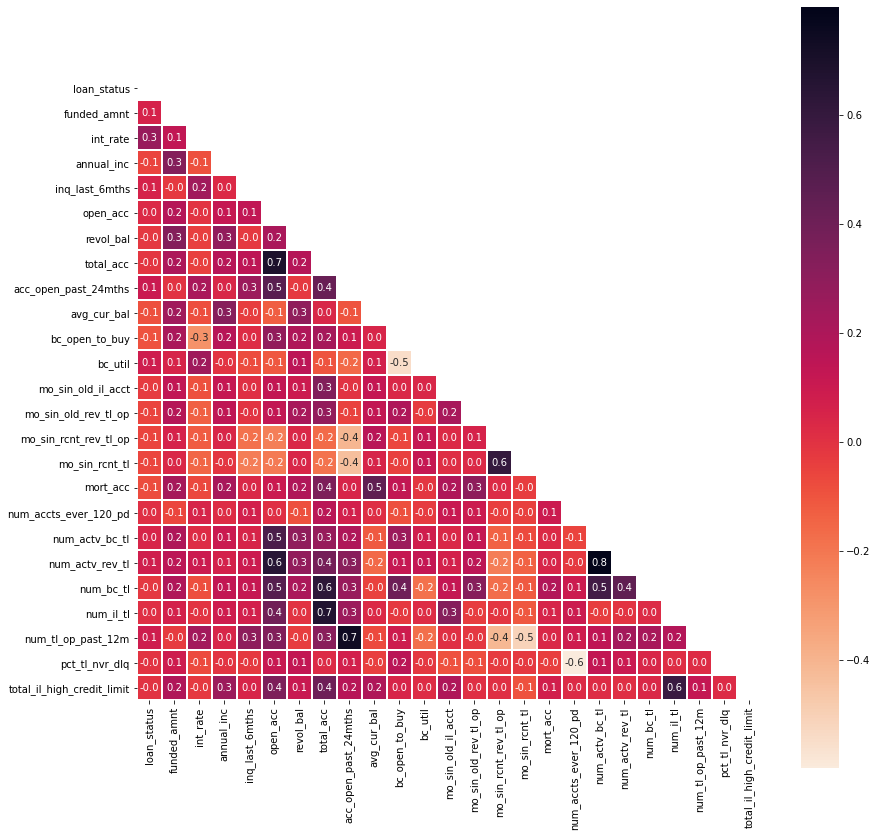

In [38]:
    # We create a mask in order to omit the superior part
mask = np.triu(np.ones_like(dataset.corr(), dtype = bool))
    
    # Figure size
f, ax = plt.subplots(figsize=(14, 14))

    # Plot with seaborn
sns.heatmap(dataset.corr(), annot = True, fmt = '.1f', mask = mask, square = True, linewidths = .5, cmap = "rocket_r");

The following variables are highly correlated:

- `num_actv_rev_tl` & `num_actv_bc_tl`: We deduce that most of the revolving trades have a bank card account associated.

- `total_acc` &  `open_acc`: This is hihgly correlated because one is included in the other.

- `mo_sin_rcnt_tl` & `mo_sin_rcnt_rev_tl_op`: If we analyze the graph we can conclude that the most recent account were revolute accounts, because they are hihgly correlated. The months since the last open are practically the same.

- `num_actv_rev_tl` & `open_acc`: According to the plot we could deduce that a great percentage of the open accounts are active revolving accounts.

- `num_il_tl` & `total_acc`: We have another type account called installment account, this is correlated with total accounts because is an account.

- `num_tl_op_past_12m` & `acc_open_past_24mths`: The total amount of accounts opened in the past 12 months is included in the accounts opened in the last 24 months.

- `total_il_high_credit_limit` & `num_il_tl`: The more installment accounts, the more high credit limit.

#### Pairplot

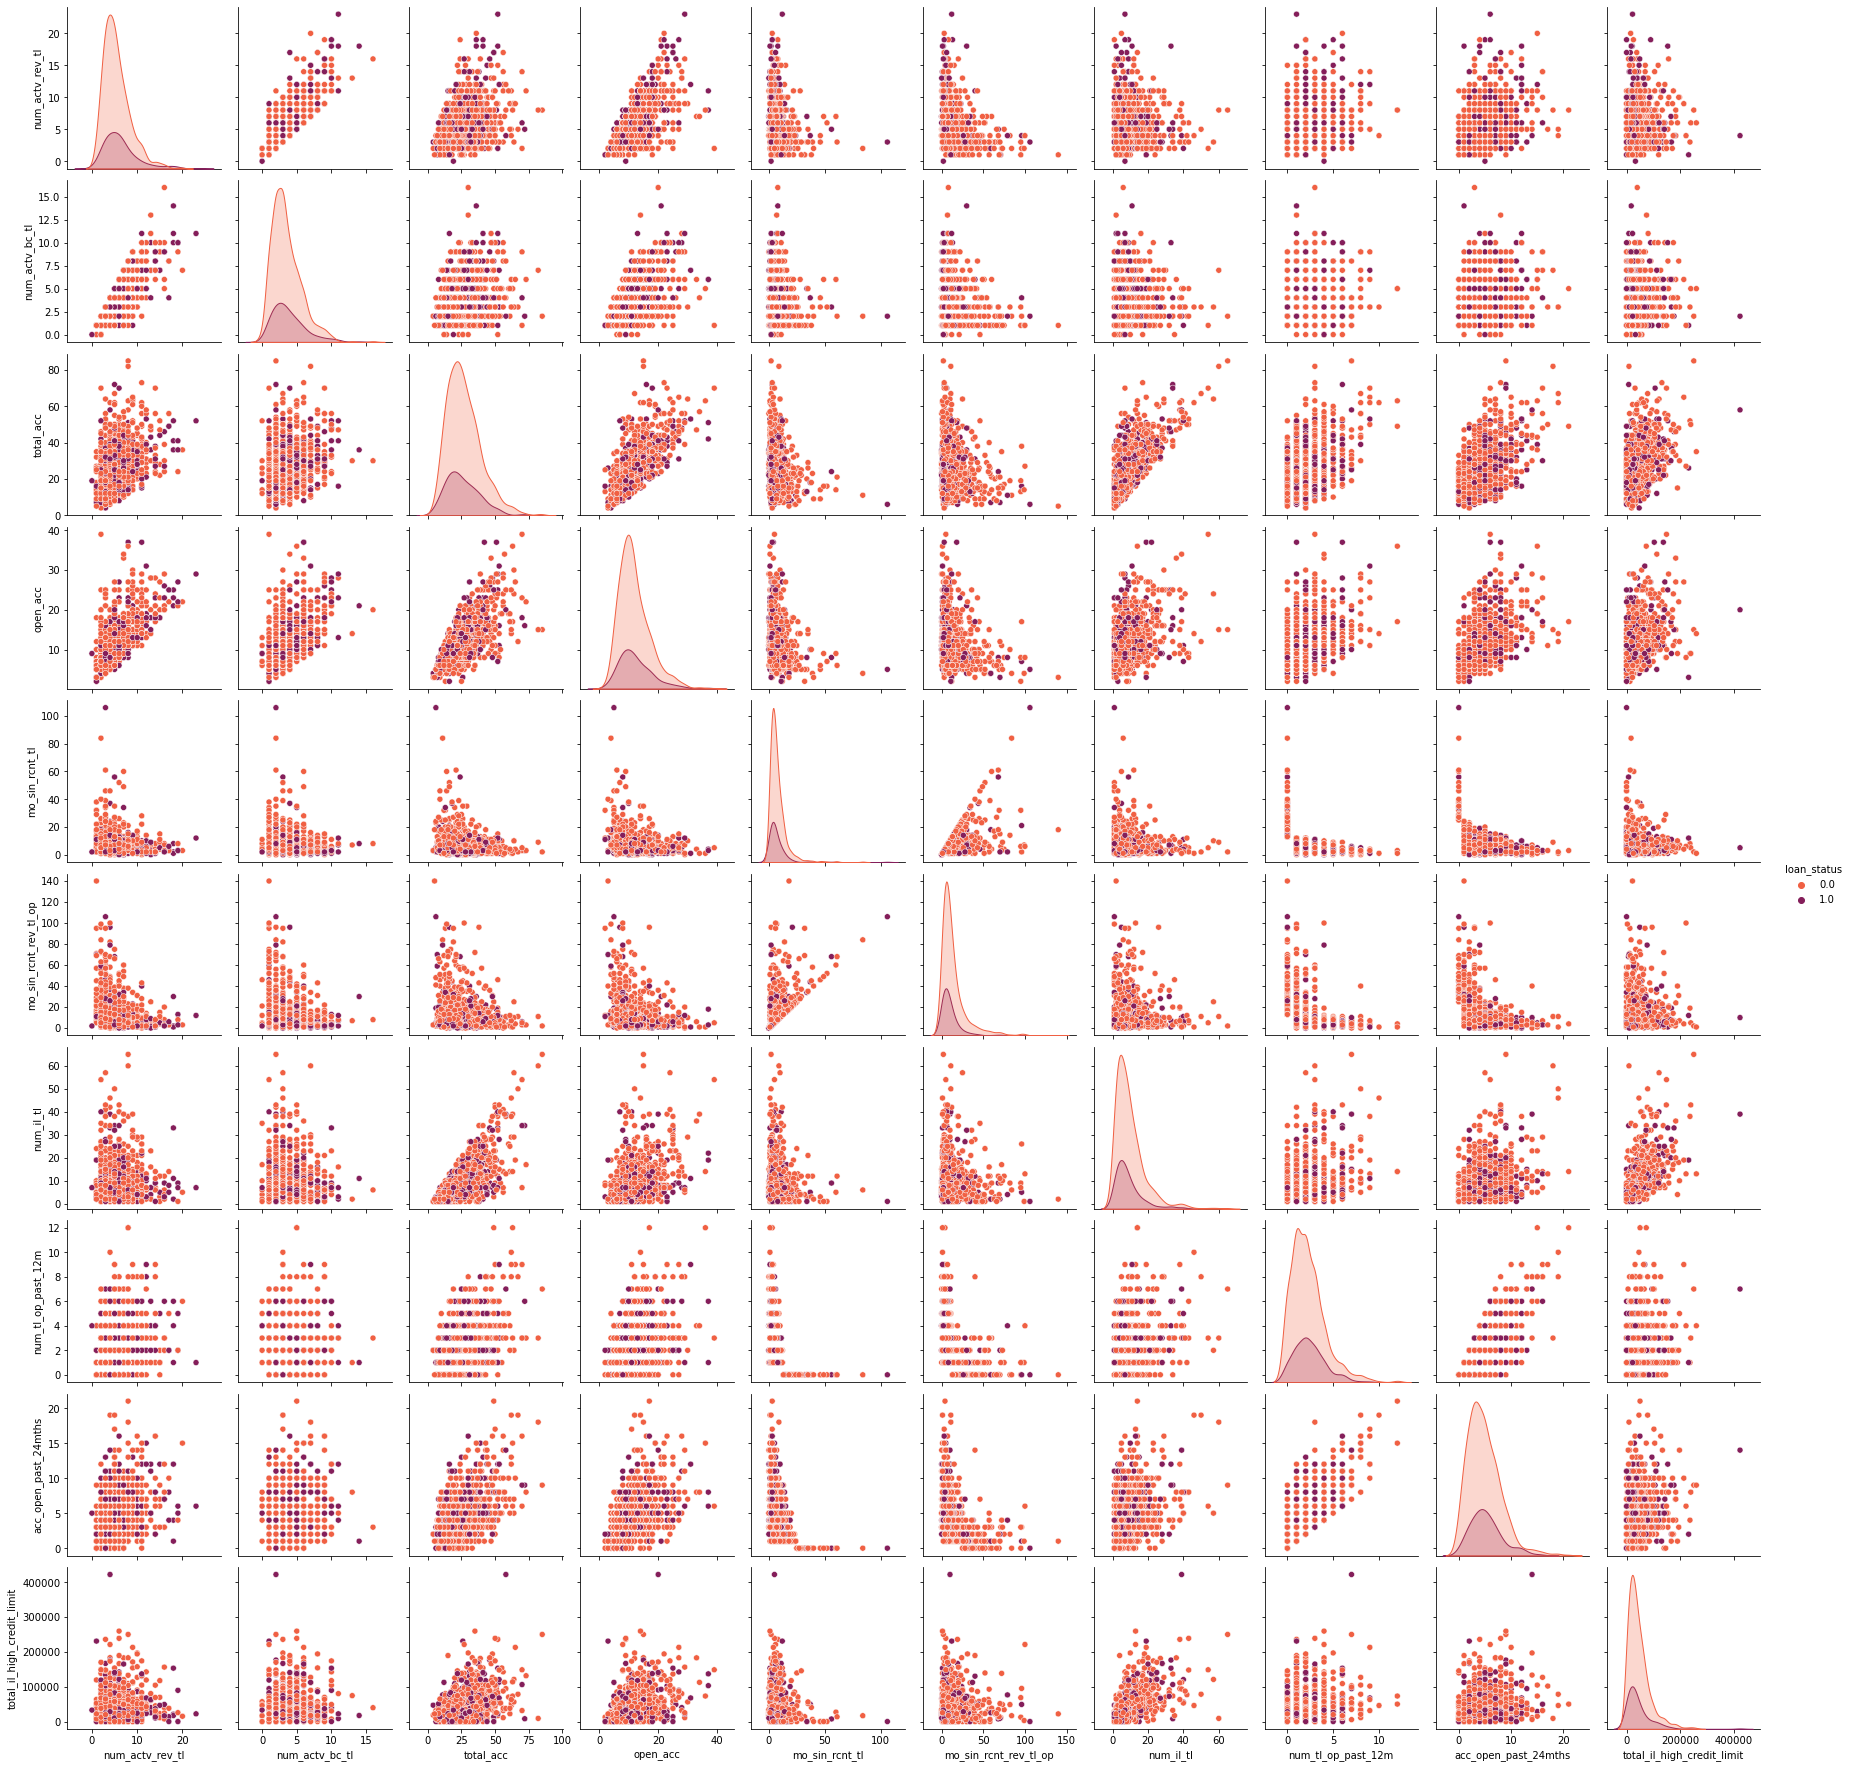

In [39]:
    # Select those columns which are high correlated
columns = ['loan_status', 'num_actv_rev_tl', 'num_actv_bc_tl', 'total_acc', 'open_acc', 'mo_sin_rcnt_tl', 
           'mo_sin_rcnt_rev_tl_op', 'num_il_tl', 'num_tl_op_past_12m', 'acc_open_past_24mths', 'total_il_high_credit_limit']

    # In order to avoid errors, we will take a sample
df_viz = dataset[columns].sample(n = 1000, replace = True, random_state = 1322)

    # For this function we will use pairplot()
sns.pairplot(df_viz, hue = 'loan_status', palette = "rocket_r");

We made a pairplot in order to visualize those correlations and we can conclude that is not as clear as we thought initially, so we are not going to drop any of them.

### Outliers

#### Boxplots

In descriptive statistics, a box plot or boxplot is a method for graphically depicting groups of numerical data through their quartiles. Box plots may also have lines extending from the boxes (whiskers) indicating variability outside the upper and lower quartiles, hence the terms box-and-whisker plot and box-and-whisker diagram. Outliers may be plotted as individual points. 

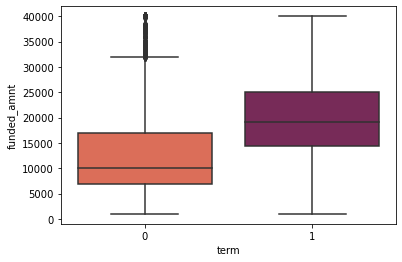

In [40]:
    # Plot with seaborn
sns.boxplot(data = dataset, x = 'term', y = 'funded_amnt', palette = 'rocket_r');

In the plot above, we can see that we have some outliers when `term` = 0 (36 months), later we will study them...

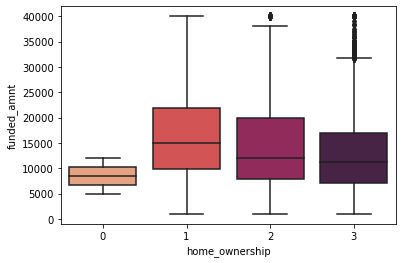

In [41]:
    # Plot with seaborn
sns.boxplot(data = dataset, x = 'home_ownership', y = 'funded_amnt', palette = 'rocket_r');

In this case, we have some outliers in the third type. Also we can see that the funded amount is higher when you are in the first one.

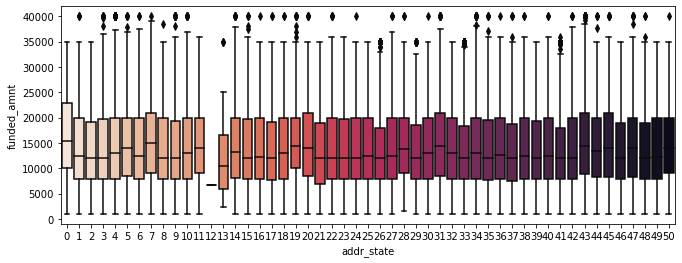

In [42]:
    # Figure size
f, ax = plt.subplots(figsize=(11, 4))

    # Plot with seaborn
sns.boxplot(data = dataset, x = 'addr_state', y = 'funded_amnt', palette = 'rocket_r');

We can see that we have some states with outliers. Apart from that, there are some states with very high amounts, as the 0.

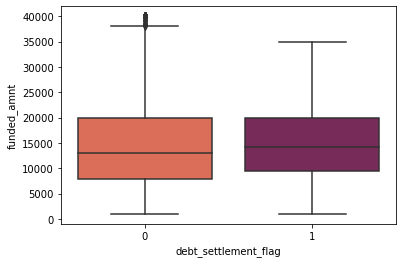

In [43]:
    # Plot with seaborn
sns.boxplot(data = dataset, x = 'debt_settlement_flag', y = 'funded_amnt', palette = 'rocket_r');

Here we have no outliers.

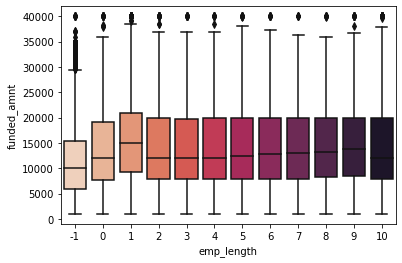

In [44]:
    # Plot with seaborn
sns.boxplot(data = dataset, x = 'emp_length', y = 'funded_amnt', palette = 'rocket_r');

We have some outliers in this variables, and is interesante that does not deppends on how many years have you been working, the mean funded amount is between 10000 and 15000. 

#### Outlier detection and dropping

After researching some outlier detection methods, we conclude that we will perform the **Interquartile range (IQR)**:

*The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, IQR = Q3 − Q1.*
*In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot on the data.*
*It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers.*

In [45]:
    # First we will calculate IQR
Q1 = dataset.quantile(0.25)
Q3 = dataset.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

loan_status                       0.0
funded_amnt                   12000.0
int_rate                          6.1
annual_inc                    43500.0
inq_last_6mths                    1.0
open_acc                          7.0
revol_bal                     13989.0
total_acc                        15.0
acc_open_past_24mths              3.0
avg_cur_bal                   15312.0
bc_open_to_buy                10263.0
bc_util                          45.1
mo_sin_old_il_acct               53.0
mo_sin_old_rev_tl_op            110.0
mo_sin_rcnt_rev_tl_op            11.0
mo_sin_rcnt_tl                    6.0
mort_acc                          3.0
num_accts_ever_120_pd             1.0
num_actv_bc_tl                    3.0
num_actv_rev_tl                   4.0
num_bc_tl                         6.0
num_il_tl                         8.0
num_tl_op_past_12m                2.0
pct_tl_nvr_dlq                    8.3
total_il_high_credit_limit    40868.5
dtype: float64


As we now have the IQR scores, it’s time to get hold on outliers. The below code will give an output with some true and false values. The data point where we have False that means these values are valid whereas True indicates presence of an outlier.

In [46]:
    # First we select only numerical variables
dataset.select_dtypes(include = ['float64', 'int64']).info()

<class 'pandas.core.frame.DataFrame'>
Index: 407321 entries, 8 to inq_last_6mths
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   loan_status                 407319 non-null  float64
 1   funded_amnt                 407319 non-null  float64
 2   int_rate                    407319 non-null  float64
 3   annual_inc                  407319 non-null  float64
 4   inq_last_6mths              407319 non-null  float64
 5   open_acc                    407319 non-null  float64
 6   revol_bal                   407319 non-null  float64
 7   total_acc                   407319 non-null  float64
 8   acc_open_past_24mths        407319 non-null  float64
 9   avg_cur_bal                 407319 non-null  float64
 10  bc_open_to_buy              407319 non-null  float64
 11  bc_util                     407319 non-null  float64
 12  mo_sin_old_il_acct          407319 non-null  float64
 13  mo_sin_old_

In [47]:
    # We select the numerical columns
columns = ['funded_amnt', 'int_rate', 'annual_inc', 'inq_last_6mths', 'open_acc', 'revol_bal', 'revol_util', 'total_acc', 
          'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op',
          'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_bc_tl', 
           'num_il_tl', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'total_il_high_credit_limit']

    # Set to NaN those which are outliers
dataset[columns] = dataset[columns][~((dataset[columns] < (Q1 - 1.5 * IQR)) |(dataset[columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [48]:
    # Drop NaN
dataset = dataset.dropna()

    # Check the results...
dataset.shape

(191397, 31)